# Data Scientist - P7 - Laurent Trichet

## Implémentez un modèle de scoring

## 3 Classification (without conversion to log)

### Import required libraries  - Constants

In [1]:
# Import default libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Import Garbage Collector (empty dataFrame memory)
import gc

# Remove some warnings
import warnings
warnings.filterwarnings('ignore')
import logging
logging.disable(logging.WARNING)


# Import Imbalanced-learn necessary tools
import imblearn
from collections import Counter

# Import for classification GradientBoostingClassifier & SVC
from sklearn import ensemble
from sklearn import svm
# Import for classification xgboost
from xgboost import XGBClassifier

# Import evaluation tool for classification optimisations
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold

# Imports tools for model interpreation, AUC, roc, permutations
from sklearn import metrics
from sklearn import inspection

# tools for execution time estimates
from datetime import datetime

# Pandas parameters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 120)
pd.set_option('display.max_info_rows', 2000)

# Matplotlib and sns visual parameters
sns.set_palette("Set1")
sns.set_style('whitegrid')
sns.set_context('paper')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11

# Constants
DIRSOURCE = '../Sources/'
DIRDATASET = './credithome_datasets/'
NUMROWS = 15000    # 1000000 to get complete dateset
# File names with NUMROWS lines and Fill nan with zeros
FILESTD_FNAN0 = DIRDATASET+'Credit_Home_Junction_Std_Fnan0_'+str(NUMROWS)+'.csv'
FILEFEAT_OUT = DIRDATASET+'Credit_Home_Features.csv'
FILEFPR_OUT = DIRDATASET+'Credit_Home_FalsePositiveRates.csv'
FILEFNR_OUT = DIRDATASET+'Credit_Home_FalseNegativeRates.csv'


### 3.1 Load training and test sets, apply correction of imbalanced classes

#### Read reduced dataset (15000) and prepare training and test features and result class

In [2]:
df = pd.read_csv(FILESTD_FNAN0, encoding='Latin-1', sep='\t')

# Retrieve train and test datasets
df_train = df[df['TARGET']!=999]
df_test = df[df['TARGET']==999]
# Keep valid columns for features and result class in future classifications
c_features = [c for c in df.columns if c not in ['index', 'TARGET', 'SK_ID_CURR']]
c_class = 'TARGET'

del df
gc.collect()

0

#### Fix imbalanced data with Prototype selection (under sample of positive class included in original sample)

In [3]:
counter1 = Counter(df_train[c_class])
print(counter1)

Counter({0.0: 13826, 1.0: 1174})


In [4]:
undersample = imblearn.under_sampling.RandomUnderSampler(random_state=0)
X, y = undersample.fit_resample(df_train[c_features], df_train[c_class])

counter2 = Counter(y)
print(counter2)

Counter({0.0: 1174, 1.0: 1174})



	Arbitrary selection of 2 variables to see effect of under sampling ...


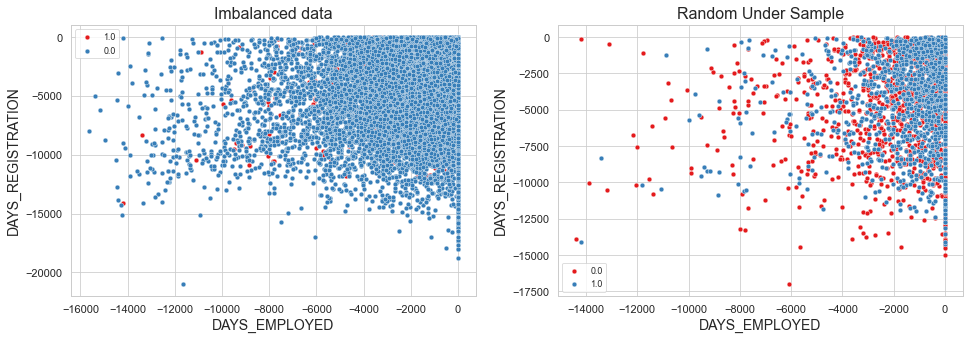

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2,
                        sharex=False, sharey=False,
                        figsize=(16,5))
fig.subplots_adjust(hspace=0.5)

for label, _ in counter1.items():
    row_ix = np.where(df_train[c_class].values == label)[0]
    sns.scatterplot(df_train[c_features].iloc[row_ix, 10],
                    df_train[c_features].iloc[row_ix, 11],
                    label=str(label),
                    ax=axes[0]
                    )
axes[0].set_title('Imbalanced data')

for label, _ in counter2.items():
    row_ix = np.where(y.values == label)[0]
    sns.scatterplot(X.iloc[row_ix, 10],
                    X.iloc[row_ix, 11],
                    label=str(label),
                    ax=axes[1]
                    )
axes[1].set_title('Random Under Sample')
print('\n\tArbitrary selection of 2 variables to see effect of under sampling ...')
plt.show()

### 3.2 Search for Classification method & Hyperparameters

#### LinearSVC, XGBCClassifier, GradientBoostingClassifier best scores

In [ ]:
models=[]
iname, itype, iparam = 0, 1, 2
models.append(['LinearSVC ', svm.LinearSVC(),
               { 
                'C': np.logspace(-4, 4, 9),
                'penalty' : ['l1', 'l2'],
                'loss': ['hinge', 'squared_hinge'],
                'dual': [False],
               }
              ])
models.append(['XGBClassifier', XGBClassifier(),
               {
                 'max_depth': [3,5],
                 'min_child_weight': [1, 5, 10],
                 'gamma': [0.5, 1, 1.5, 2, 5],
                 'subsample': [0.6, 0.8, 1.0],
                 'colsample_bytree': [0.6, 0.8, 1.0],
                 'verbosity': [0],
               }
              ])
models.append(['GradBoostC', ensemble.GradientBoostingClassifier(),
               {
                'n_estimators': [200],
                'max_depth': [3,5],
                'criterion': ['friedman_mse', 'squared_error'],
                'min_samples_split': [2, 3, 4],
                'min_weight_fraction_leaf': [0.0, 0.2, 0.4],
               }
              ])
for i, model in enumerate(models):
    mdl = GridSearchCV(model[itype], model[iparam], cv=5, scoring='roc_auc')
    datedeb = datetime.now()
    mdl.fit(X, y)
    duree = datetime.now() - datedeb
    print(f'{model[iname]} \tduree: {duree.seconds}s \tbest_score: {mdl.best_score_:4.3} \tbest_params: {mdl.best_params_}')


> For a 1174 '1 and 0 balanced classes' sample:  
  
>> LinearSVC  	duree: 112s 	best_score: 0.696 	best_params: {'C': 0.1, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}  
>>  
>>  XGBClassifier 	duree: 1663s 	best_score: 0.723 	best_params: {'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 1.0, 'verbosity': 0}  
>>  
>>  GradBoostC 	duree: 1631s 	best_score: 0.732 	best_params: {'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.2, 'n_estimators': 200}

In [ ]:
del df_train, df_test
gc.collect()

### 3.3 Kfold Roc Curve and Feature Importances

In [6]:
n_splits = 8
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

tot_valid_y = np.zeros(y.shape[0])
tot_valid_prob = np.zeros(y.shape[0])
tot_score = []
tot_feature_importances = []

for splt, (train_idx, valid_idx) in enumerate(skf.split(X, y)):

    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    valid_x, valid_y = X.iloc[valid_idx], y.iloc[valid_idx]
    
    # GradientBoostingClassifier
    gbc = ensemble.GradientBoostingClassifier(
        n_estimators=200,
        criterion='friedman_mse',
        max_depth=3,
        min_samples_split=2,
        min_weight_fraction_leaf=0.2,
    )
    gbc.fit(train_x, train_y)

    tot_valid_y[valid_idx] = valid_y
    
    valid_prob = gbc.predict_proba(valid_x)[:,1]
    tot_valid_prob[valid_idx] = valid_prob
    
    tot_score.append(metrics.roc_auc_score(valid_y.values, valid_prob))
    tot_feature_importances.append(gbc.feature_importances_)
    
tot_score = [round(1000*s)/1000 for s in tot_score] 
mean_score = sum(tot_score)/len(tot_score)
print(f'tot_score   = {[s for s in tot_score]}')
print(f'mean scores = {mean_score:5.3}')

tot_score   = [0.738, 0.746, 0.768, 0.738, 0.741, 0.669, 0.719, 0.71]
mean scores = 0.729


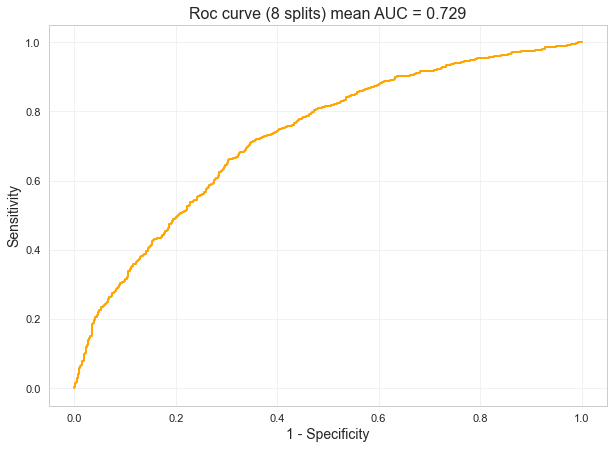

In [7]:

fig, axe = plt.subplots(figsize=(10,7))
[fpr, tpr, thr] = metrics.roc_curve(tot_valid_y,
                                    tot_valid_prob,
                                    pos_label=1)
axe.plot(fpr, tpr, color='orange', lw=2)
axe.set_title(f'Roc curve ({n_splits} splits) mean AUC = {mean_score:5.3}')
axe.set_xlabel('1 - Specificity')
axe.set_ylabel('Sensitivity')
axe.grid(visible=True, color='#eeeeee')

plt.show()


##### Threshold 1: MINIMIZE THE RISK : we want to minimize the rate of False Positive, i.e minimize the pourcentage of loans attributed to wrong clients.

In [8]:
# Display thresholds for different False Positive Rate (FPR) tolerances
list_r = []
for max_fpr in np.arange(0.05, 0.65, 0.05):
    idx = np.max(np.where(fpr<max_fpr))
    str1 = f'False Pos Rate max {max_fpr:.2f} '
    str2 = f'Sensitivity: {tpr[idx]:.2f},  Specificity: {1-fpr[idx]:.2f} Threshold: {thr[idx]:.2f}'
    print(str1+str2)
    list_r.append([f'{max_fpr:.2f}',f'{thr[idx]:.2f}'])

# Record file with FPR and thresholds
df_fpr = pd.DataFrame(list_r, columns=['fpr', 'threshold'])
df_fpr.to_csv(FILEFPR_OUT, sep='\t', index=False)
del df_fpr
gc.collect()

False Pos Rate max 0.05 Sensitivity: 0.22,  Specificity: 0.95 Threshold: 0.78
False Pos Rate max 0.10 Sensitivity: 0.31,  Specificity: 0.90 Threshold: 0.72
False Pos Rate max 0.15 Sensitivity: 0.41,  Specificity: 0.85 Threshold: 0.66
False Pos Rate max 0.20 Sensitivity: 0.49,  Specificity: 0.80 Threshold: 0.61
False Pos Rate max 0.25 Sensitivity: 0.56,  Specificity: 0.75 Threshold: 0.57
False Pos Rate max 0.30 Sensitivity: 0.65,  Specificity: 0.70 Threshold: 0.52
False Pos Rate max 0.35 Sensitivity: 0.71,  Specificity: 0.65 Threshold: 0.47
False Pos Rate max 0.40 Sensitivity: 0.74,  Specificity: 0.60 Threshold: 0.44
False Pos Rate max 0.45 Sensitivity: 0.78,  Specificity: 0.55 Threshold: 0.41
False Pos Rate max 0.50 Sensitivity: 0.82,  Specificity: 0.50 Threshold: 0.37
False Pos Rate max 0.55 Sensitivity: 0.85,  Specificity: 0.45 Threshold: 0.35
False Pos Rate max 0.60 Sensitivity: 0.88,  Specificity: 0.40 Threshold: 0.32


98

##### Threshold 2: OPTIMIZE THE TURNOVER : we want to minimize the rate of False Negative, i.e minimize the pourcentage of loans refused to good clients.

In [9]:
# Display thresholds for different False Negative Rate (FNR) tolerances
# FNR = 1 - TPR
list_r = []
for min_tpr in np.arange(0.40, 1, 0.05):
    idx = np.min(np.where(tpr>min_tpr))
    str1 = f'False Neg Rate max {1-min_tpr:.2f} '
    str2 = f'Sensitivity: {tpr[idx]:.2f},  Specificity: {1-fpr[idx]:.2f} Threshold: {thr[idx]:.2f}'
    print(str1+str2)
    list_r.append([f'{1-min_tpr:.2f}',f'{thr[idx]:.2f}'])

# Record file with FNR and thresholds
df_fnr = pd.DataFrame(list_r, columns=['fpr', 'threshold'])
df_fnr.to_csv(FILEFNR_OUT, sep='\t', index=False)
del df_fnr
gc.collect()

False Neg Rate max 0.60 Sensitivity: 0.40,  Specificity: 0.86 Threshold: 0.67
False Neg Rate max 0.55 Sensitivity: 0.45,  Specificity: 0.82 Threshold: 0.63
False Neg Rate max 0.50 Sensitivity: 0.50,  Specificity: 0.80 Threshold: 0.61
False Neg Rate max 0.45 Sensitivity: 0.55,  Specificity: 0.76 Threshold: 0.57
False Neg Rate max 0.40 Sensitivity: 0.60,  Specificity: 0.72 Threshold: 0.54
False Neg Rate max 0.35 Sensitivity: 0.65,  Specificity: 0.70 Threshold: 0.52
False Neg Rate max 0.30 Sensitivity: 0.70,  Specificity: 0.66 Threshold: 0.48
False Neg Rate max 0.25 Sensitivity: 0.75,  Specificity: 0.59 Threshold: 0.43
False Neg Rate max 0.20 Sensitivity: 0.80,  Specificity: 0.53 Threshold: 0.39
False Neg Rate max 0.15 Sensitivity: 0.85,  Specificity: 0.44 Threshold: 0.34
False Neg Rate max 0.10 Sensitivity: 0.90,  Specificity: 0.36 Threshold: 0.30
False Neg Rate max 0.05 Sensitivity: 0.95,  Specificity: 0.21 Threshold: 0.22


16

#### Shape features and importances to find features with main role in classification

In [10]:
importance_mean = pd.DataFrame(tot_feature_importances).mean().to_list()
importance_std = pd.DataFrame(tot_feature_importances).std().to_list()
df_features = pd.DataFrame(data=np.array([[c for c in X.columns], importance_mean, importance_std]).T,
                           columns=['col name', 'mean def', 'std def'])
df_features['mean def'] = df_features['mean def'].astype('float64')
df_features['std def'] = df_features['std def'].astype('float64')
df_features.describe()

,mean def,std def
count,771.000000,771.000000
mean,0.001297,0.000579
std,0.008584,0.001353
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000208,0.000447
max,0.185261,0.015108


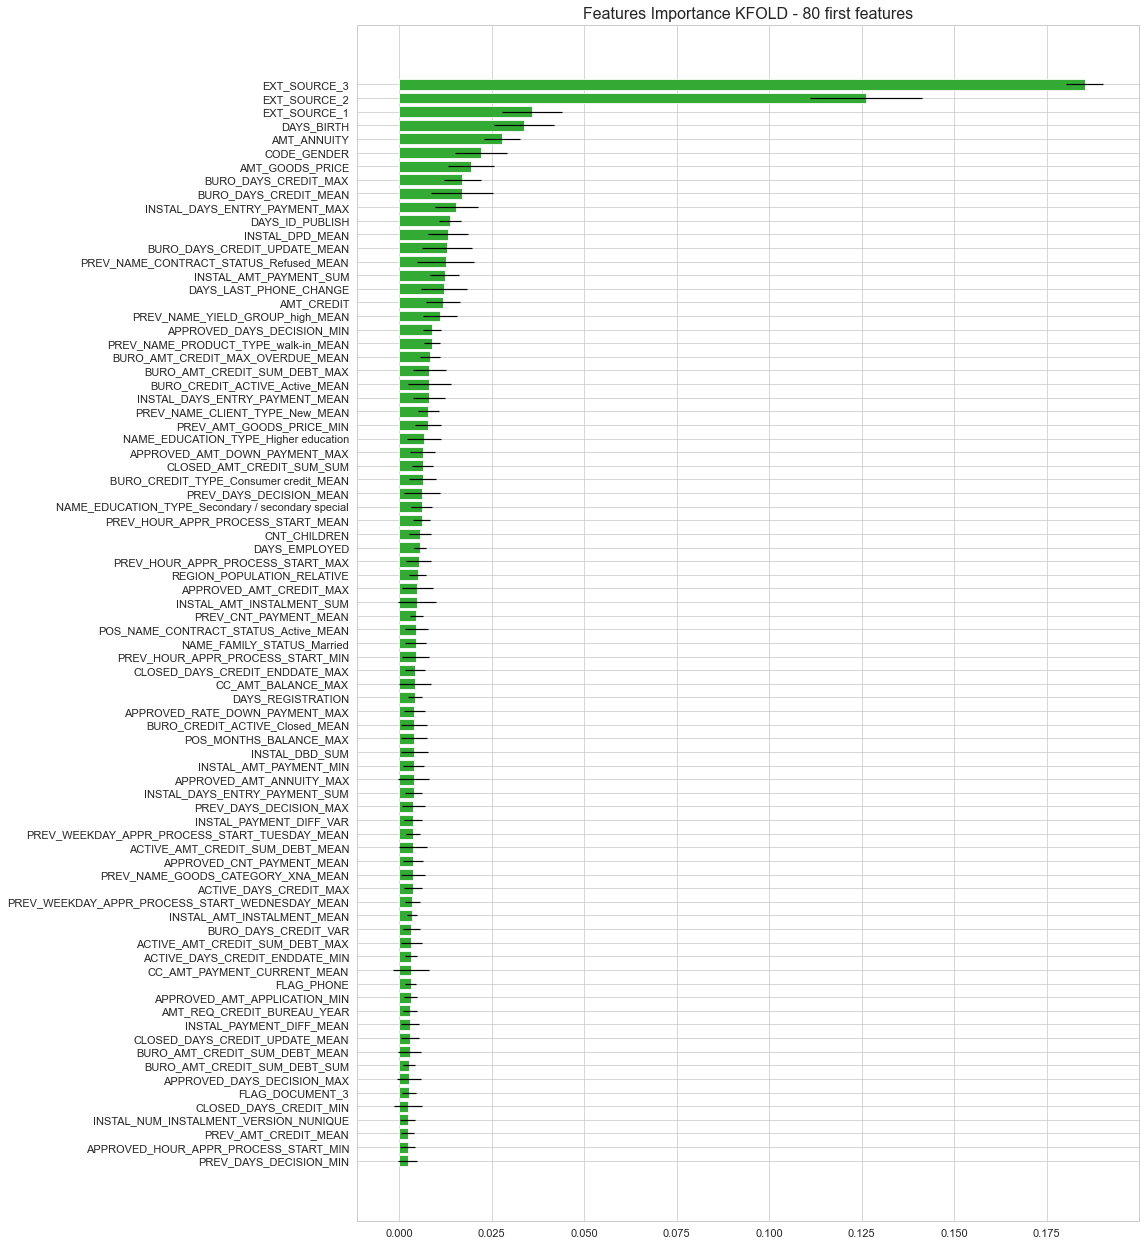

In [11]:

df_draw = df_features.sort_values('mean def')
df_draw = df_draw.iloc[-80:,:]
fig, axes = plt.subplots(figsize=(14,int(df_draw.shape[0]//3.5)))
axes.barh([x for x in range(df_draw.shape[0])],
           df_draw['mean def'].values,
           xerr = df_draw['std def'].values,
           color = '#33aa33',
           tick_label=df_draw['col name'].values)
axes.set_title(f'Features Importance KFOLD - {df_draw.shape[0]} first features')
axes.grid(visible=True)
plt.show()


### 3.4 Permutation Feature Importance

In [12]:
gbc = ensemble.GradientBoostingClassifier(
        n_estimators=200,
        criterion='friedman_mse',
        max_depth=3,
        min_samples_split=3,
        min_weight_fraction_leaf=0.2,
    )
gbc.fit(X, y)

result = inspection.permutation_importance(gbc, X, y, n_repeats=8, random_state=0)

In [13]:
df_featpermut = pd.DataFrame(data=np.array([[c for c in X.columns], result.importances_mean, result.importances_std]).T,
                   columns=['col permut', 'mean permut', 'std permut'])
df_featpermut['mean permut'] = df_featpermut['mean permut'].astype('float64')
df_featpermut['std permut'] = df_featpermut['std permut'].astype('float64')
df_featpermut.describe()

,mean permut,std permut
count,771.000000,771.000000
mean,0.000362,0.000217
std,0.001491,0.000606
min,-0.001224,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,0.023744,0.007264


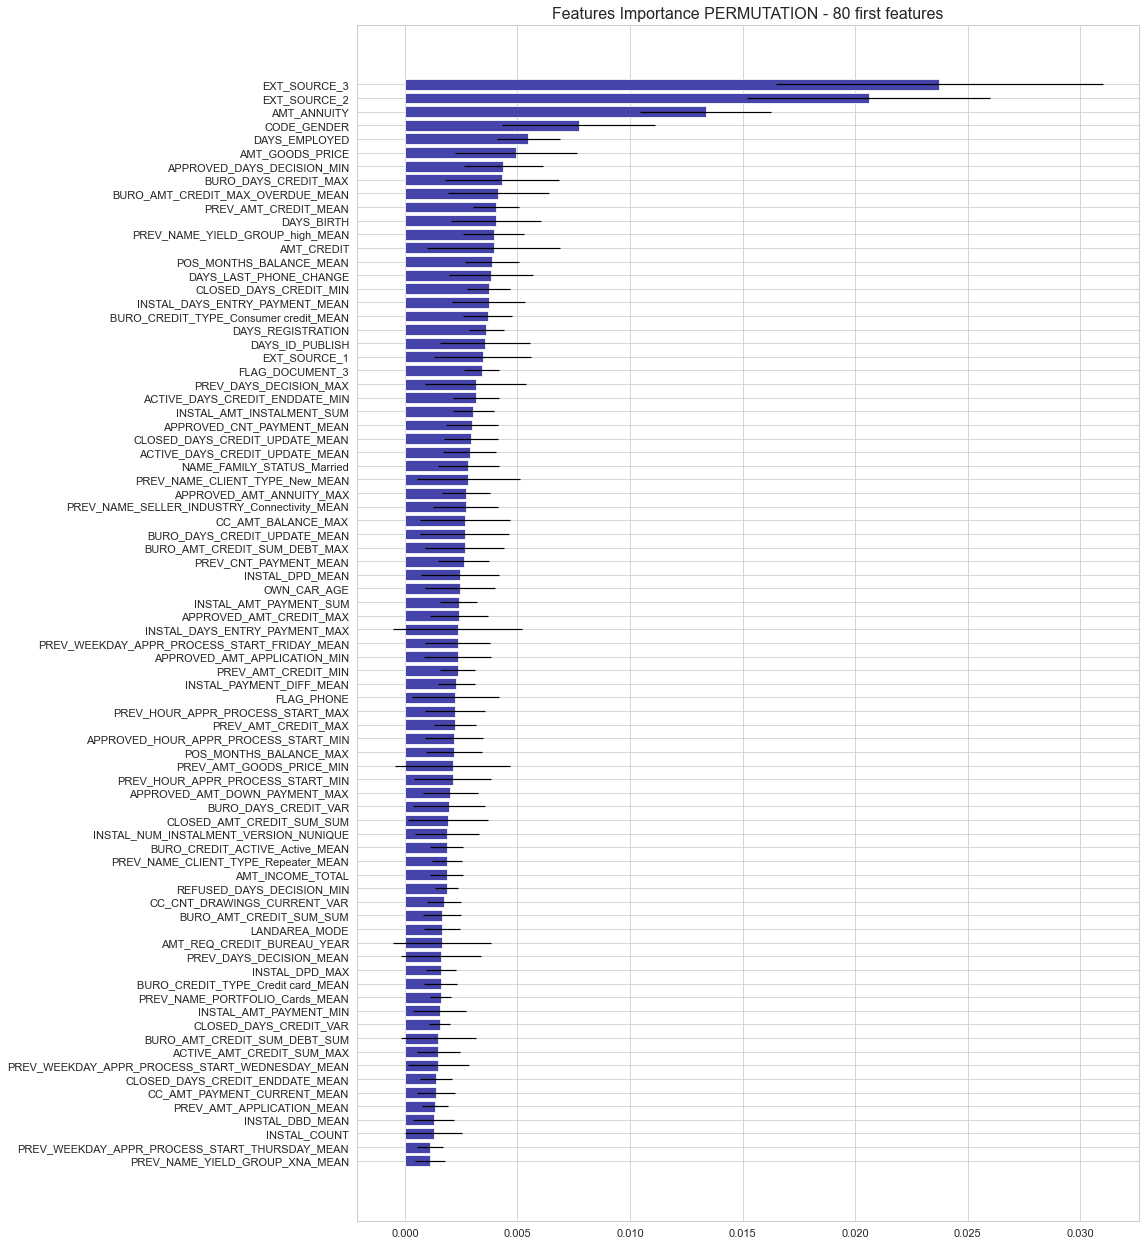

In [14]:
df_draw = df_featpermut.sort_values('mean permut')
df_draw = df_draw.iloc[-80:,:]
fig, axes = plt.subplots(figsize=(14,int(df_draw.shape[0]//3.5)))
axes.barh([x for x in range(df_draw.shape[0])],
           df_draw['mean permut'].values,
           xerr = df_draw['std permut'].values,
           color = '#4444aa',
           tick_label=df_draw['col permut'].values)
axes.set_title(f'Features Importance PERMUTATION - {df_draw.shape[0]} first features')
axes.grid(visible=True)
plt.show()


### 3.5 Combination Kfold and Permutation Feature Importance

In [15]:
df_feat = pd.concat([df_features, df_featpermut], axis=1)
df_feat.drop('col permut', axis=1, inplace=True)

del df_features, df_featpermut
gc.collect()

20531

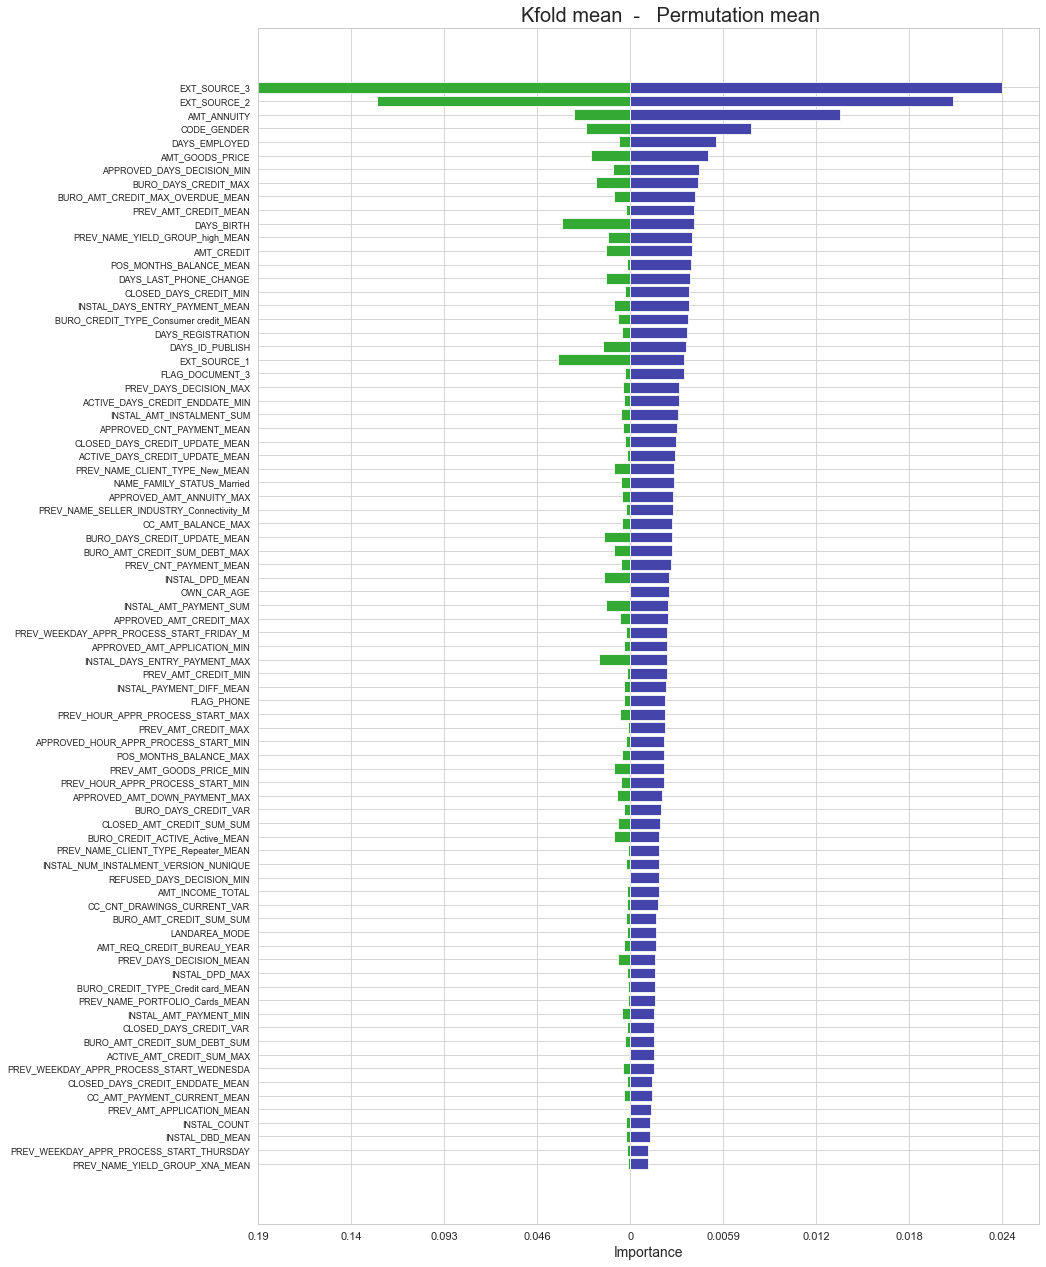

In [16]:
df_draw = df_feat.sort_values('mean permut')
df_draw = df_draw.iloc[-80:,:].sort_values('mean permut', ascending=False)
max_val = max(df_draw['mean def'].max(), df_draw['mean permut'].max())
ratio1 = 100/df_draw['mean def'].max()
ratio2 = 100/df_draw['mean permut'].max()
barWidth=0.8
plt.figure(figsize=(14,int(len(df_draw)/3.5)))
plt.gca().invert_yaxis()
plt.barh(df_draw['col name'].str[:40], df_draw['mean def']*ratio1,
         left=100-(df_draw['mean def']*ratio1), color='#33aa33')
plt.barh(df_draw['col name'].str[:40], df_draw['mean permut']*ratio2,
         left=100, color ='#4444aa')
plt.title('        Kfold mean  -   Permutation mean', fontsize=20)
plt.yticks(fontsize=9, color='#222222')
plt.xlabel('Importance')
label_max_left = df_draw['mean def'].max()
label_max_right = df_draw['mean permut'].max()
labels = [
          f'{label_max_left:4.2}', f'{label_max_left*0.75:4.2}',
          f'{label_max_left*0.5:4.2}', f'{label_max_left*0.25:4.2}',
          '0',
          f'{label_max_right*0.25:4.2}', f'{label_max_right*0.5:4.2}',
          f'{label_max_right*0.75:4.2}', f'{label_max_right:4.2}',
          ]
plt.xticks(np.arange(0,225, step=25), labels)
plt.grid(True)


In [17]:
df_feat['mean importance'] = (df_feat['mean def'] + df_feat['mean permut']) / 2
df_feat['std importance'] = (df_feat['std def'] + df_feat['std permut']) / 2


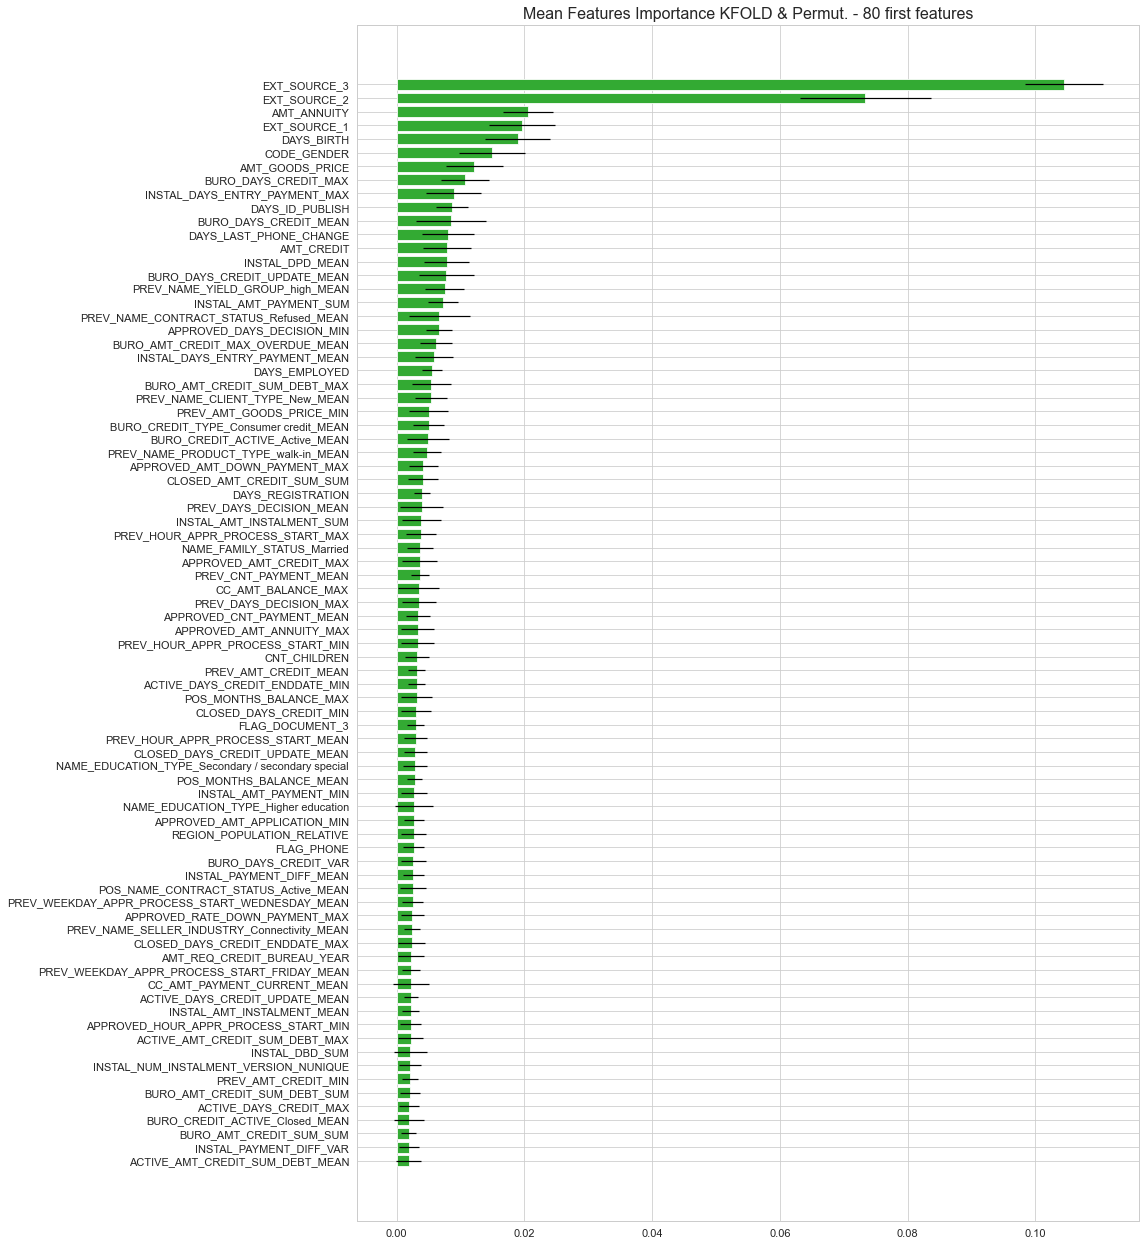

In [18]:
df_draw = df_feat.sort_values('mean importance')
df_draw = df_draw.iloc[-80:,:]
fig, axes = plt.subplots(figsize=(14,int(df_draw.shape[0]//3.5)))
axes.barh([x for x in range(df_draw.shape[0])],
           df_draw['mean importance'].values,
           xerr = df_draw['std importance'].values,
           color = '#33aa33',
           tick_label=df_draw['col name'].values)
axes.set_title(f'Mean Features Importance KFOLD & Permut. - {df_draw.shape[0]} first features')
axes.grid(visible=True)
plt.show()


### 3.6 Save File Dict with Feature Importance, Description, Min, Max & Mean

In [19]:
df_feat = df_feat.drop(columns=['mean def', 'std def', 'mean permut', 'std permut'])\
                 .sort_values('mean importance', ascending=False)

def round_imp(c):
    return round(100*c)/100

df_feat['mean importance'] = df_feat['mean importance'].map(round_imp)

In [20]:
df_descr = pd.read_csv(DIRSOURCE+'HomeCredit_columns_description.csv',
                             encoding='Latin-1')

def get_col_HC_description(c):
    i = 0
    colname = c
    descr = '(Application) '
    if c.startswith('BURO_'):
        colname = c[5:]
        descr = '(Bureau) '
    if c.startswith('PREV_'):
        colname = c[5:]
        descr = '(Previous Application) '
    if c.startswith('APPROVED_'):
        colname = c[9:]
        descr = '(Previous Application) '
    if c.startswith('REFUSED_'):
        colname = c[8:]
        descr = '(Previous Application) '
    if c.startswith('POS_'):
        colname = c[4:]
        descr = '(POS CASH Balance) '
    if c.startswith('INSTAL_'):
        colname = c[7:]
        descr = '(Installments Payments) '
    if c.startswith('CC_'):
        colname = c[3:]
        descr = '(Credit Card Balance) '
    while i < df_descr.shape[0]:
        if colname.startswith(str(df_descr.iloc[i,:]['Row'])):
            if colname.endswith('_MEAN'):
                descr = descr + 'MEAN, '
            if colname.endswith('_MAX'):
                descr = descr + 'MAX, '
            if colname.endswith('_MIN'):
                descr = descr + 'MIN, '
            if colname.endswith('_SUM'):
                descr = descr + 'SUM, '
            descr = descr + str(df_descr.iloc[i,:]['Description']).replace('\t', ' ')
            break
        i = i + 1
    return descr

In [21]:
df_feat['description'] = df_feat['col name'].map(get_col_HC_description)

del df_descr
gc.collect()

31028

In [22]:
NUMROWS = 15000    # 1000000 to get complete dateset
# File names with NUMROWS lines and Fill nan with zeros
FILESTD_FNAN0 = DIRDATASET+'Credit_Home_Junction_Std_Fnan0_'+str(NUMROWS)+'.csv'

df = pd.read_csv(FILESTD_FNAN0, encoding='Latin-1', sep='\t')

In [24]:
df_pos = df[df['TARGET']==1]

def calc_positive_min(c):
    return round(100*df_pos[c].min())/100

def calc_positive_max(c):
    return round(100*df_pos[c].max())/100

def calc_positive_mean(c):
    return round(100*df_pos[c].mean())/100

df_feat['min positive'] = df_feat['col name'].map(calc_positive_min)
df_feat['max positive'] = df_feat['col name'].map(calc_positive_max)
df_feat['mean positive'] = df_feat['col name'].map(calc_positive_mean)


In [25]:
df_neg = df[df['TARGET']==0]

def calc_negative_min(c):
    return round(100*df_neg[c].min())/100

def calc_negative_max(c):
    return round(100*df_neg[c].max())/100

def calc_negative_mean(c):
    return round(100*df_neg[c].mean())/100

df_feat['min negative'] = df_feat['col name'].map(calc_negative_min)
df_feat['max negative'] = df_feat['col name'].map(calc_negative_max)
df_feat['mean negative'] = df_feat['col name'].map(calc_negative_mean)


In [26]:
df_feat.to_csv(FILEFEAT_OUT, sep='\t', index=False)